In [1]:
import glob
import random
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import numpy as np
import math
import itertools
import datetime
import time
from torchvision.utils import save_image, make_grid
from torchvision import datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt


from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def to_rgb(image):
  rgb_image = Image.new("RGB", image.size)
  rgb_image.paste(image)
  return rgb_image

class ImageDataset(Dataset):
  def __init__(self,root,transforms_=None, unaligned=False,mode = "train"):
    self.transform = transforms.Compose(transforms_)
    self.unaligned = unaligned

    if mode == "train":
      self.files_A = sorted(glob.glob(os.path.join(root,"trainA") + "/*.*"))
      self.files_B = sorted(glob.glob(os.path.join(root,"trainB") + "/*.*"))
    else:
      self.files_A = sorted(glob.glob(os.path.join(root,"testA") + "/*.*"))
      self.files_B = sorted(glob.glob(os.path.join(root,"testB") + "/*.*")) 

  def __getitem__(self,index):
    image_A = Image.open(self.files_A[index % len(self.files_A)])
    if self.unaligned:
      image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
    else:
      Image_B = Image.open(self.files_B[index % len(self.files_B)])

    if image_A.mode != "RGB":
      image_A = to_rgb(image_A)
    if image_B.mode != "RGB":
      image_B = to_rgb(image_B)

    item_A = self.transform(image_A)
    item_B = self.transform(image_B)

    return {"A": item_A, "B" : item_B}

  def __len__(self):
    return max(len(self.files_A) , len(self.files_B))


In [3]:
def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m,"bias") and m.bias is not None:
      torch.nn.init.constant_(m.bias.data,0.0)

  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data,1.0,0.02)
    torch.nn.init.constant_(m.bias.data,0.0)
    

In [4]:
class ResidualBlock(nn.Module):
  def __init__(self, in_features):
    super(ResidualBlock, self).__init__()
    #self.block = nn.Sequential(nn.ReflectionPad2d(1), nn.conv2d(in_features, infeatures, 3), nn.InstanceNorm2d(in_features), nn.ReLU(inplace = True), nn.ReflectionPad2d(1), nn.Conv2d(in_features, in_features, 3), nn.InstanceNorm2d(in_features)  )
    self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )    
  def forward(self,x):
    return x + self.block(x)




In [5]:
class GeneratorResNet(nn.Module):
  def __init__(self,input_shape, num_residual_blocks):
    super(GeneratorResNet, self).__init__()
    channels = input_shape[0]
    out_features =64
    model = [nn.ReflectionPad2d(channels), nn.Conv2d(channels, out_features, 7), nn.InstanceNorm2d(out_features), nn.ReLU(inplace = True)]
    in_features = out_features

    for _ in range(2):
      out_features *=2
      model +=[ nn.Conv2d(in_features, out_features, 3, stride=2, padding=1), nn.InstanceNorm2d(out_features), nn.ReLU(inplace = True)]
      in_features = out_features

    
    for _ in range(num_residual_blocks):
      model += [ResidualBlock(out_features)]

    for _ in range(2):
      out_features //=2
      model += [ nn.Upsample(scale_factor = 2), nn.Conv2d(in_features, out_features, 3, stride=1, padding=1), nn.InstanceNorm2d(out_features), nn.ReLU(inplace = True)]
      in_features = out_features

    model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh() ]
    self.model = nn.Sequential(*model)
  
  def forward(self,x):
    return self.model(x)
    

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)


In [7]:
dataset_name = "mincho"
channels = 3
img_height = 256
img_width = 256
n_residual_blocks = 9
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_epochs = 401
init_epoch = 0
decay_epoch = (n_epochs-init_epoch)//2
lambda_cyc = 10.0
lambda_id = 5.0
n_cpu = 4
batch_size =3
sample_interval = 20
checkpoint_interval = 20



In [8]:
os.makedirs("images/%s" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)


criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (channels, img_height, img_width)
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [9]:
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

G_AB.load_state_dict(torch.load("/content/drive/Shareddrives/실전기계학습/cyclegan60-60/model/G_AB_260.pth"))
G_BA.load_state_dict(torch.load("/content/drive/Shareddrives/실전기계학습/cyclegan60-60/model/G_BA_260.pth"))
D_A.load_state_dict(torch.load("/content/drive/Shareddrives/실전기계학습/cyclegan60-60/model/D_A_260.pth"))
D_B.load_state_dict(torch.load("/content/drive/Shareddrives/실전기계학습/cyclegan60-60/model/D_B_260.pth"))

<All keys matched successfully>

In [10]:
cuda = torch.cuda.is_available()
if cuda:
  G_AB = G_AB.cuda()
  G_BA = G_BA.cuda()
  D_A = D_A.cuda()
  D_B = D_B.cuda()
  criterion_GAN.cuda()
  criterion_cycle.cuda()
  criterion_identity.cuda()

In [ ]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [11]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr = lr, betas = (b1,b2)
)

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas = (b1,b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas = (b1,b2))

In [12]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)


In [13]:
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda = LambdaLR(n_epochs, init_epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda = LambdaLR(n_epochs, init_epoch, decay_epoch).step
)

lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda = LambdaLR(n_epochs, init_epoch, decay_epoch).step
)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [14]:
class ReplayBuffer:
  def __init__(self,max_size = 50):
    assert max_size > 0, "Empty buffer or trying to create a block hole. Be careful."

    self.max_size = max_size
    self.data = []

  def push_and_pop(self,data):
    to_return = []
    for element in data.data:
      element = torch.unsqueeze(element,0)
      if len(self.data) < self.max_size:
        self.data.append(element)
        to_return.append(element)
      else:
        if random.uniform(0,1) > 0.5:
          i = random.randint(0,self.max_size -1)
          to_return.append(self.data[i].clone())
          self.data[i] = element
        else:
          to_return.append(element)
    return Variable(torch.cat(to_return))

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [15]:
transforms_ = [
               transforms.Resize(int(img_height * 1.12) , Image.BICUBIC),
               transforms.RandomCrop((img_height, img_width)),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5)),
]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [17]:
#Training Data loader
dataloader = DataLoader(
    ImageDataset("/content/drive/MyDrive/Colab Notebooks/data/%s" % dataset_name, transforms_ = transforms_, unaligned = True),
    batch_size = 1,
    shuffle = True,
    num_workers = 4,
)
#Test data loader
val_dataloader = DataLoader(
    ImageDataset("/content/drive/MyDrive/Colab Notebooks/data/%s" % dataset_name, transforms_ = transforms_, unaligned=True, mode= "test"),
    batch_size = 1,
    shuffle = False,
    num_workers = 1,

)

In [21]:
def make_images(i):
  imgs = next(iter(val_dataloader))
  G_AB.eval()
  G_BA.eval()
  real_A = Variable(imgs["A"].type(Tensor))
  fake_B = G_AB(real_A)
  real_B = Variable(imgs["B"].type(Tensor))
  fake_A = G_BA(real_B)

  real_A = make_grid(real_A, nrow=5, normalize=True)
  real_B = make_grid(real_B, nrow=5, normalize=True)
  fake_A = make_grid(fake_A, nrow=5, normalize=True)
  fake_B = make_grid(fake_B, nrow=5, normalize=True)

  image_grid = torch.cat((real_A,fake_B),2)
  save_image(image_grid, "/content/drive/Shareddrives/실전기계학습/최종결과사진/%s.png" %i, normalize = False)

In [ ]:
def sample_images(batches_done):
  imgs = next(iter(val_dataloader))
  G_AB.eval()
  G_BA.eval()
  real_A = Variable(imgs["A"].type(Tensor))
  fake_B = G_AB(real_A)
  real_B = Variable(imgs["B"].type(Tensor))
  fake_A = G_BA(real_B)

  real_A = make_grid(real_A, nrow=5, normalize=True)
  real_B = make_grid(real_B, nrow=5, normalize=True)
  fake_A = make_grid(fake_A, nrow=5, normalize=True)
  fake_B = make_grid(fake_B, nrow=5, normalize=True)

  image_grid = torch.cat((real_A,fake_B,real_B,fake_A),1)
  save_image(image_grid, "/content/drive/Shareddrives/실전기계학습/cyclegan60-60/%s/%s.png" % (dataset_name, batches_done), normalize = False)

In [ ]:
Dlosslist = []
Glosslist = []
cyclelist = []
identitylist = []
epochlist = []

valDlosslist = []
valGlosslist = []
valcyclelist = []
validentitylist = []
epochlist = []

In [ ]:
torch.cuda.empty_cache()

In [ ]:
prev_time = time.time()
for epoch in range(init_epoch, n_epochs):
  Dlossavg = 0
  Glossavg = 0
  cycleavg = 0
  identityavg = 0

  valDlossavg = 0
  valGlossavg=0
  valcycleavg = 0
  validentityavg=0

  batchcount =0
  for i, batch in enumerate(dataloader):
    real_A = Variable(batch["A"].type(Tensor))
    real_B = Variable(batch["B"].type(Tensor))

    valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
    fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

    G_AB.train()
    G_BA.train()
    optimizer_G.zero_grad()

    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)
    loss_identity = (loss_id_A + loss_id_B)/2

    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
    loss_GAN = (loss_GAN_AB + loss_GAN_BA) /2

    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)
    loss_cycle = (loss_cycle_A + loss_cycle_B)

    loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

    loss_G.backward()
    optimizer_G.step()

    optimizer_D_A.zero_grad()

    loss_real = criterion_GAN(D_A(real_A), valid)

    fake_A_ = fake_A_buffer.push_and_pop(fake_A)
    loss_fake = criterion_GAN(D_A(fake_A_.detach()),fake)

    loss_D_A = (loss_real + loss_fake) /2
    loss_D_A.backward()
    optimizer_D_A.step()

    optimizer_D_B.zero_grad()

    loss_real = criterion_GAN(D_B(real_B), valid)

    fake_B_ = fake_B_buffer.push_and_pop(fake_B)
    loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)

    loss_D_B = (loss_real + loss_fake) / 2
    loss_D_B.backward()
    optimizer_D_B.step()
    loss_D = (loss_D_A + loss_D_B) /2

    batches_done = epoch * len(dataloader) + i +1
    print(len(dataloader), batches_done)
    batches_left = n_epochs * len(dataloader) - batches_done
    time_left = datetime.timedelta(seconds = batches_left * (time.time() - prev_time))

    prev_time = time.time()


    sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )
    Dlossavg += loss_D.item()
    Glossavg += loss_G.item()
    cycleavg += loss_cycle.item()
    identityavg += loss_identity.item()
    batchcount +=1
    if batches_done % 20 == 0:
      sample_images(epoch)
      '''
      for i2,b2 in enumerate(val_dataloader):
        rA = Variable(batch["A"].type(Tensor))
        rB = Variable(batch["B"],type(Tensor))
        v = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        f = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        l_id_A = criterion_identity(G_BA(rA),rA)
        l_id_B = criterion_identity(G_AB(rB),RB)
        l_i = (l_id_A + l_id_B) /2
        fB = G_AB(real_A)
        l_G_AB = criterion_GAN(D_B(fB),v)
        fA = G_BA(real_B)
        l_G_BA = criterion_GAN(D_A(fA),v)
        l_G = (l_G_AB + l_G_BA) /2

        rec_A = G_BA(fB)
        l_c_A = criterion_cycle(rec_A,rA)
        rec_B = G_AB(fA)
        l_c_B = criterion_cycle(rec_B,rB)
        l_c = (l_c_A + l_c_B) /2

        l_G = l_G + lambda_cyc*l_c + lambda_id * l_i    ##lossG
        
        l_r = criertion_GAN(D_A(rA),v)
        fA2 = fake_A_buffer.push_and_pop(fA)
        l_f = fake_A_buffer(D_A(fA2.detach()),f)
        l_D_A = (l_r + l_f)  /2


        l_r = criterion_GAN(D_B(rB),v)
        fB2 = fake_B_buffer.push_and_pop(fB)
        l_f = criterion_GAN(D_B(fB2.detach()),f)
        l_D_B = (l_r + l_f)/2

        l_D = (l_D_A + l_D_B)/2
      '''
###  crossvalidation

    rA = Variable(batch["A"].type(Tensor))
    rB = Variable(batch["B"].type(Tensor))
    v = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
    f = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)
    l_id_A = criterion_identity(G_BA(rA),rA)
    l_id_B = criterion_identity(G_AB(rB),rB)
    l_i = (l_id_A + l_id_B) /2
    fB = G_AB(real_A)
    l_G_AB = criterion_GAN(D_B(fB),v)
    fA = G_BA(real_B)
    l_G_BA = criterion_GAN(D_A(fA),v)
    l_G = (l_G_AB + l_G_BA) /2

    rec_A = G_BA(fB)
    l_c_A = criterion_cycle(rec_A,rA)
    rec_B = G_AB(fA)
    l_c_B = criterion_cycle(rec_B,rB)
    l_c = (l_c_A + l_c_B) /2

    l_G = l_G + lambda_cyc*l_c + lambda_id * l_i    ##lossG
          
    l_r = criterion_GAN(D_A(rA),v)
    fA2 = fake_A_buffer.push_and_pop(fA)
    l_f = criterion_GAN(D_A(fA2.detach()),f)
    l_D_A = (l_r + l_f)  /2


    l_r = criterion_GAN(D_B(rB),v)
    fB2 = fake_B_buffer.push_and_pop(fB)
    l_f = criterion_GAN(D_B(fB2.detach()),f)
    l_D_B = (l_r + l_f)/2

    l_D = (l_D_A + l_D_B)/2
    valDlossavg += l_D.item()
    valGlossavg += l_G.item()
    valcycleavg += l_c.item()
    validentityavg += l_i.item()
    

###


  Dlossavg /= batchcount
  Glossavg /= batchcount
  cycleavg /= batchcount
  identityavg /= batchcount

  valDlossavg /= batchcount
  valGlossavg /= batchcount
  valcycleavg /= batchcount
  validentityavg /= batchcount

  epochlist.append(epoch)
  Dlosslist.append(Dlossavg)
  Glosslist.append(Glossavg)
  cyclelist.append(cycleavg)
  identitylist.append(identityavg)

  valDlosslist.append(valDlossavg)
  valGlosslist.append(valGlossavg)
  valcyclelist.append(valcycleavg)
  validentitylist.append(validentityavg)


  lr_scheduler_G.step()
  lr_scheduler_D_A.step()
  lr_scheduler_D_B.step()

  if checkpoint_interval != -1 and epoch % checkpoint_interval ==0:
    torch.save(G_AB.state_dict(), "/content/drive/Shareddrives/실전기계학습/cyclegan60-60/model/G_AB_%d.pth" % epoch)  
    torch.save(G_BA.state_dict(), "/content/drive/Shareddrives/실전기계학습/cyclegan60-60/model/G_BA_%d.pth" % epoch)    
    torch.save(D_A.state_dict(), "/content/drive/Shareddrives/실전기계학습/cyclegan60-60/model/D_A_%d.pth" % epoch)   
    torch.save(D_B.state_dict(), "/content/drive/Shareddrives/실전기계학습/cyclegan60-60/model/D_B_%d.pth" % epoch)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[Epoch 326/401] [Batch 26/67] [D loss: 0.083232] [G loss: 2.404140, adv: 0.665058, cycle: 0.136753, identity: 0.074310] ETA: 0:36:03.17995467 21870
[Epoch 326/401] [Batch 27/67] [D loss: 0.063341] [G loss: 3.388938, adv: 0.873719, cycle: 0.198944, identity: 0.105156] ETA: 0:35:20.84877667 21871
[Epoch 326/401] [Batch 28/67] [D loss: 0.068546] [G loss: 2.149674, adv: 0.760089, cycle: 0.112911, identity: 0.052094] ETA: 0:35:36.71318167 21872
[Epoch 326/401] [Batch 29/67] [D loss: 0.075848] [G loss: 2.166997, adv: 0.760981, cycle: 0.114459, identity: 0.052286] ETA: 0:35:42.15306467 21873
[Epoch 326/401] [Batch 30/67] [D loss: 0.070040] [G loss: 2.662204, adv: 0.769616, cycle: 0.154342, identity: 0.069833] ETA: 0:35:24.58104867 21874
[Epoch 326/401] [Batch 31/67] [D loss: 0.142296] [G loss: 2.346573, adv: 0.670659, cycle: 0.129846, identity: 0.075491] ETA: 0:35:45.89038267 21875
[Epoch 326/401] [Batch 32/67] [D loss: 0.046026] [G loss: 2.152865, adv: 0.8

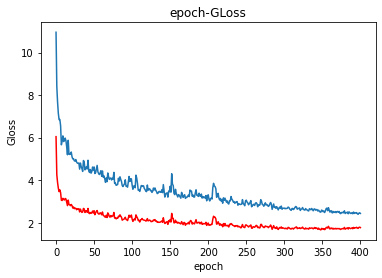

In [ ]:
plt.plot(epochlist,Glosslist,epochlist,valGlosslist,'r-')
plt.xlabel('epoch')
plt.ylabel('Gloss')
plt.title("epoch-GLoss")
plt.show()

In [ ]:
plt.plot(epochlist,valGlosslist,'r-')
plt.xlabel('epoch')
plt.ylabel('Gloss')
plt.title("epoch-GLoss")
plt.show()

<function matplotlib.pyplot.plot>

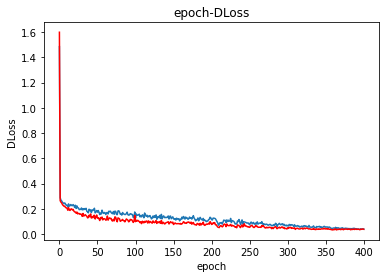

In [ ]:
plt.plot(epochlist,Dlosslist,epochlist,valDlosslist, 'r-')
plt.xlabel('epoch')
plt.ylabel('DLoss')
plt.title("epoch-DLoss")
plt.plot

<function matplotlib.pyplot.plot>

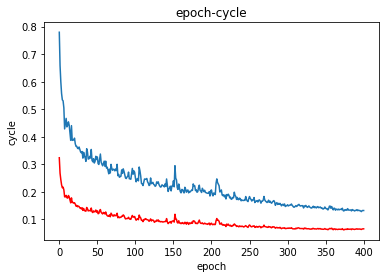

In [ ]:
plt.plot(epochlist,cyclelist,epochlist,valcyclelist, 'r-')
plt.xlabel('epoch')
plt.ylabel('cycle')
plt.title("epoch-cycle")
plt.plot

[]

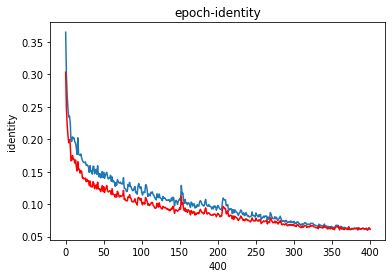

In [ ]:
plt.plot(epochlist,identitylist,epochlist,validentitylist, '-r')
plt.xlabel(epoch)
plt.ylabel('identity')
plt.title("epoch-identity")
plt.plot()

In [22]:
for i,batch in enumerate(val_dataloader):
  make_images(i)

In [ ]:
torch.save(G_AB.state_dict(), "/content/drive/MyDrive/Colab Notebooks/data/model/G_AB_%d.pth" % epoch)    
torch.save(G_BA.state_dict(), "/content/drive/MyDrive/Colab Notebooks/data/model/G_BA_%d.pth" % epoch)    
torch.save(D_A.state_dict(), "/content/drive/MyDrive/Colab Notebooks/data/model/D_A_%d.pth" % epoch)    
torch.save(D_B.state_dict(), "/content/drive/MyDrive/Colab Notebooks/data/model/D_B_%d.pth" % epoch)   